In [1]:
import etl
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import joblib

In [5]:
def inference_pipeline(model, data, preprocessor, ignore_vars=None, ordinal_feats=[]):
    # 1-Preprocess data
    #data = etl.preprocess(data)
    
    # 2-Transformation steps
    if "Severity" in data.columns:
        X = data.drop(columns=["Severity"]).copy()
    else:
        X = data.copy()
    
    # Ignore certain columns
    if ignore_vars is None:
        ignore_vars = []
        
    X = X[[c for c in X.columns if c not in ignore_vars]]
    
    X_transformed = preprocessor.transform(X)
    
    # 3-Inference
    predictions = model.predict(X_transformed)
    
    return predictions

In [6]:
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.3f}, F1 Score: {f1:.3f}, Cohen's Kappa: {kappa:.3f}")

### Load model

In [7]:
model = joblib.load("models/xgb_model_20241001_144429.pkl")
preprocessor = joblib.load("models/xgb_preprocessor_20241001_144429.pkl")

### Load data

In [8]:
df = pd.read_csv("data/US_Accidents_March23.csv")
df = df[(df["State"] == "MA") & (df["City"] == "Boston")]
df.shape

(4866, 46)

In [9]:
df = etl.preprocess(df)
df.shape

(4802, 14)

In [10]:
df["Severity"].value_counts()

2    3309
3    1356
1     109
4      28
Name: Severity, dtype: int64

### Inference

In [11]:
target_transformer = OrdinalEncoder(categories=[[1, 2, 3, 4]])
y_true = target_transformer.fit_transform(df["Severity"].values.reshape(-1, 1)).ravel()

In [12]:
y_true.shape

(4802,)

In [13]:
%%time
y_pred = inference_pipeline(model=model, data=df, preprocessor=preprocessor, ignore_vars=None, ordinal_feats=["Month"])

CPU times: total: 625 ms
Wall time: 235 ms


C:\Users\ngoum\anaconda3\envs\dl-env\lib\site-packages\xgboost\core.py:160: UserWarning: [16:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [14]:
evaluate(y_true, y_pred)

Accuracy: 0.705, F1 Score: 0.716, Cohen's Kappa: 0.403


In [15]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.15      0.18      0.16       109
         1.0       0.86      0.71      0.78      3309
         2.0       0.54      0.74      0.62      1356
         3.0       0.05      0.07      0.06        28

    accuracy                           0.70      4802
   macro avg       0.40      0.43      0.41      4802
weighted avg       0.75      0.70      0.72      4802



In [21]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    # Plot confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False, xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

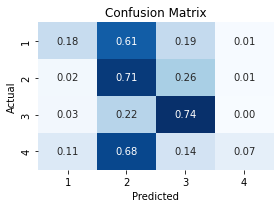

In [22]:
plot_confusion_matrix(y_true, y_pred)